In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')

/home/yue/anaconda3/envs/yad2k/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [75]:
#Load Frozen inference graph files.
#SSD_GRAPH_FILE = 'ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
SSD_GRAPH_FILE = 'ssd_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'

In [76]:
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

def filter_boxes(min_score, boxes, scores, classes):
    n = len(classes)
    idxs = []
    
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    
    return filtered_boxes, filtered_scores, filtered_classes



def to_image_coords(boxes, height, width):
    
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords


def draw_boxes(image, boxes, classes, thickness=4):
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
    


def load_graph(graph_file):
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Number of colors = 148


In [77]:
detection_graph = load_graph(SSD_GRAPH_FILE)

image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')


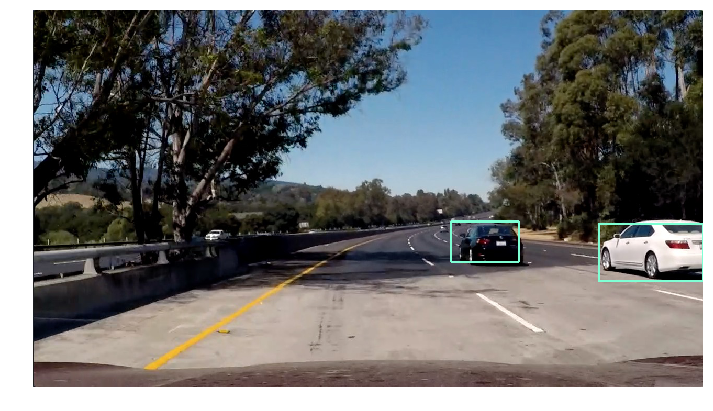

In [78]:
image = Image.open('./test_images/test5.jpg')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:
    boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor:image_np})
    
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)
    
    min_score = 0.55
    
    boxes, scores, classes = filter_boxes(min_score, boxes, scores, classes)
    
    width, height = image.size
    boxes_coords = to_image_coords(boxes, height, width)
    
    draw_boxes(image, boxes_coords, classes)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')


In [79]:
def pipeline(image):
    draw_image = Image.fromarray(image)
    image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
    
    boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor:image_np})
    
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)
    
    min_score = 0.55
    
    boxes, scores, classes = filter_boxes(min_score, boxes, scores, classes)
    
    width, height = draw_image.size
    
    box_coords = to_image_coords(boxes, height, width)
    
    draw_boxes(draw_image, box_coords, classes)
    
    return np.array(draw_image)

In [80]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip = VideoFileClip('project_video.mp4')

with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('project_out_inception_v2_coco.mp4')

chunk:   9%|▉         | 102/1112 [00:00<00:01, 965.05it/s, now=None]

Moviepy - Building video project_out_inception_v2_coco.mp4.
MoviePy - Writing audio in %s


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]                 

MoviePy - Done.
Moviepy - Writing video project_out_inception_v2_coco.mp4



Moviepy - Done !
Moviepy - video ready project_out_inception_v2_coco.mp4


In [81]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('project_out_inception_v2_coco.mp4'))